In [ ]:
pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install focal_loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2L
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from Bio import SeqIO
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from focal_loss import SparseCategoricalFocalLoss
from sklearn.utils import shuffle

## Chargement des données

In [ ]:
def load_fasta_and_encode(path):
  AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
  AA_TO_INT = {aa: i+1 for i, aa in enumerate(AMINO_ACIDS)}
  sequences = []
  for record in SeqIO.parse(path, "fasta"):
      seq = [AA_TO_INT.get(residue, 0) for residue in str(record.seq)]
      sequences.append(seq)
  return np.array(sequences, dtype="object")

In [ ]:
gpcr = load_fasta_and_encode("GPCR.fasta")
protease = load_fasta_and_encode("Protease.fasta")
p450 = load_fasta_and_encode("P450.fasta")
ferritin = load_fasta_and_encode("Ferritin.fasta")

In [ ]:
gpcr = np.stack((gpcr, np.zeros(gpcr.shape)), axis=1)
protease = np.stack((protease, np.ones(protease.shape)), axis=1)
p450 = np.stack((p450, np.ones(p450.shape)*2), axis=1)
ferritin = np.stack((ferritin, np.ones(ferritin.shape)*3), axis=1)

In [ ]:
print(gpcr.shape)
print(protease.shape)
print(p450.shape)
print(ferritin.shape)

(3369, 2)
(519, 2)
(252, 2)
(35, 2)


In [ ]:
df_sequences = pd.DataFrame(np.vstack((gpcr, protease, p450, ferritin)), columns=["sequences", "label"])
df_sequences

,sequences,label
0,"[11, 6, 6, 4, 1, 6, 1, 3, 6, 13, 15, 6, 15, 18...",0.0
1,"[11, 15, 10, 10, 1, 10, 16, 6, 10, 10, 2, 11, ...",0.0
2,"[11, 7, 15, 7, 8, 10, 8, 10, 5, 10, 5, 6, 2, 1...",0.0
3,"[11, 16, 12, 5, 17, 13, 3, 1, 2, 12, 18, 3, 16...",0.0
4,"[11, 9, 18, 10, 2, 17, 18, 10, 18, 18, 17, 10,...",0.0
...,...,...
4170,"[11, 16, 17, 9, 17, 12, 18, 18, 4, 18, 10, 12,...",3.0
4171,"[11, 12, 9, 14, 18, 8, 4, 18, 10, 12, 9, 14, 1...",3.0
4172,"[11, 9, 17, 8, 12, 16, 18, 3, 17, 9, 4, 5, 10,...",3.0
4173,"[17, 4, 10, 6, 17, 3, 13, 12, 1, 9, 17, 13, 16...",3.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sequences["sequences"], df_sequences["label"], test_size=0.2, random_state=42)

In [ ]:
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post', maxlen=X_train.shape[1])
y_train = y_train.astype("int32")
y_test = y_test.astype("int32")

In [ ]:
MAX_LEN = X_train.shape[1]

## LSTM

In [ ]:
input_layer = Input(shape=(MAX_LEN,), dtype="int32")

x = layers.Embedding(input_dim=21, output_dim=8)(input_layer)
x = layers.Bidirectional(LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(LSTM(128))(x)

output_layer = layers.Dense(4, activation="softmax")(x)

model_lstm = Model(inputs=input_layer, outputs=output_layer)
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7839)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 7839, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7839, 128)      │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,740 (1.15 MB)

 Trainable params: 301,740 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_lstm_weighted.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_lstm.compile(optimizer="adam", loss=SparseCategoricalFocalLoss(4, class_weight=[0.1, 0.3, 0.3, 0.3]), metrics=["accuracy"])

In [ ]:
model_lstm.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7968 - loss: 0.0385
Epoch 1: val_accuracy improved from -inf to 0.81557, saving model to best_model_lstm_weighted.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 107s 920ms/step - accuracy: 0.7968 - loss: 0.0385 - val_accuracy: 0.8156 - val_loss: 0.0370
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8127 - loss: 0.0324
Epoch 2: val_accuracy improved from 0.81557 to 0.82036, saving model to best_model_lstm_weighted.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 137s 910ms/step - accuracy: 0.8126 - loss: 0.0325 - val_accuracy: 0.8204 - val_loss: 0.0375
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.8120 - loss: 0.0336
Epoch 3: val_accuracy did not improve from 0.82036
105/105 ━━━━━━━━━━━━━━━━━━━━ 95s 909ms/step - accuracy: 0.8119 - loss: 0.0336 - val_accuracy: 0.8132 - val_loss: 0.0367
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.7815 - loss: 0.0301
Epoch 4: val_accuracy did not im

In [ ]:
with open('history_lstm_weighted.json', 'w') as f:
    json.dump(model_lstm.history.history, f)

## Evaluation LSTM

In [ ]:
best_model_lstm_weighted = load_model("best_model_lstm_weighted.keras")

with open('history_lstm_weighted.json', 'r') as f:
    history_lstm_weighted_dict = json.load(f)

In [ ]:
y_pred_probs = best_model_lstm_weighted.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step


In [ ]:
print("\nClassification Report:")
class_names = ['GPCR', 'Protease', 'P450', 'Ferritin']
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        GPCR       0.84      0.97      0.90       681
    Protease       0.53      0.26      0.35        99
        P450       0.00      0.00      0.00        43
    Ferritin       0.00      0.00      0.00        12

    accuracy                           0.82       835
   macro avg       0.34      0.31      0.31       835
weighted avg       0.75      0.82      0.77       835



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


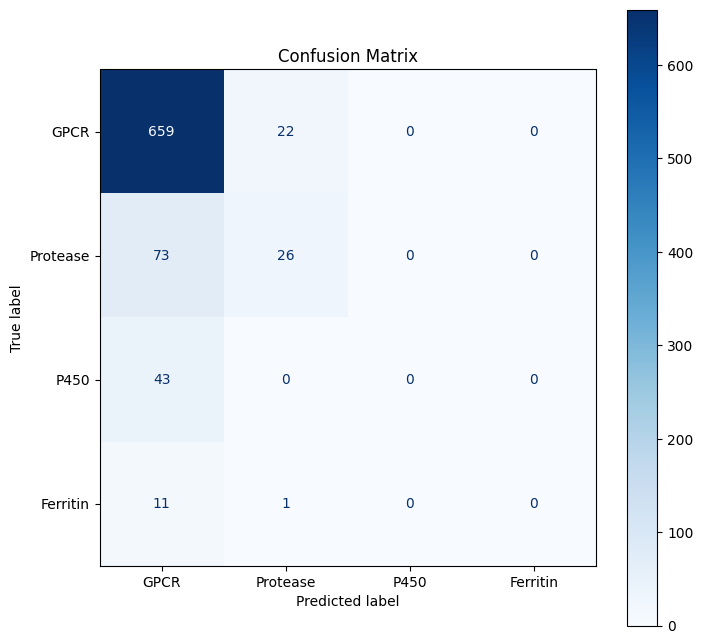

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Convolution1D

In [ ]:
input_layer = Input(shape=(MAX_LEN,), dtype="int32")

x = layers.Embedding(input_dim=21, output_dim=8)(input_layer)
x = layers.Conv1D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalAveragePooling1D()(x)
output_layer = layers.Dense(4, activation="softmax")(x)

model_cnn = Model(inputs=input_layer, outputs=output_layer)
model_cnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7839)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 7839, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7837, 64)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3918, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3916, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1958, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,988 (105.42 KB)

 Trainable params: 26,988 (105.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc_cnn = tf.keras.callbacks.ModelCheckpoint('best_model_cnn.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_cnn.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[es_cnn, mc_cnn])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7820 - loss: 0.6819
Epoch 1: val_accuracy improved from -inf to 0.84910, saving model to best_model_cnn.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7825 - loss: 0.6808 - val_accuracy: 0.8491 - val_loss: 0.5610
Epoch 2/30
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8576 - loss: 0.5219
Epoch 2: val_accuracy improved from 0.84910 to 0.85030, saving model to best_model_cnn.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8578 - loss: 0.5215 - val_accuracy: 0.8503 - val_loss: 0.5487
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8700 - loss: 0.4867
Epoch 3: val_accuracy did not improve from 0.85030
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8699 - loss: 0.4868 - val_accuracy: 0.8479 - val_loss: 0.5486
Epoch 4/30
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8648 - loss: 0.4997
Epoch 4: val_accuracy improved from 0.85030 to 0.85389, saving 

In [ ]:
with open('history_cnn.json', 'w') as f:
    json.dump(model_cnn.history.history, f)

## Modèles LSTM pour classification binaire GPCR

In [ ]:
gpcr1 = load_fasta_and_encode("GPCR.fasta")
protease1 = load_fasta_and_encode("Protease.fasta")
p4501 = load_fasta_and_encode("P450.fasta")
ferritin1 = load_fasta_and_encode("Ferritin.fasta")

In [ ]:
gpcr1 = np.stack((gpcr1, np.zeros(gpcr1.shape)), axis=1)
protease1 = np.stack((protease1, np.ones(protease1.shape)), axis=1)
p4501 = np.stack((p4501, np.ones(p4501.shape)), axis=1)
ferritin1 = np.stack((ferritin1, np.ones(ferritin1.shape)), axis=1)

In [ ]:
df_sequences_binary1 = pd.DataFrame(np.vstack((gpcr1, protease1, p4501, ferritin1)), columns=["sequences", "label"])
df_sequences_binary1

,sequences,label
0,"[11, 6, 6, 4, 1, 6, 1, 3, 6, 13, 15, 6, 15, 18...",0.0
1,"[11, 15, 10, 10, 1, 10, 16, 6, 10, 10, 2, 11, ...",0.0
2,"[11, 7, 15, 7, 8, 10, 8, 10, 5, 10, 5, 6, 2, 1...",0.0
3,"[11, 16, 12, 5, 17, 13, 3, 1, 2, 12, 18, 3, 16...",0.0
4,"[11, 9, 18, 10, 2, 17, 18, 10, 18, 18, 17, 10,...",0.0
...,...,...
4170,"[11, 16, 17, 9, 17, 12, 18, 18, 4, 18, 10, 12,...",1.0
4171,"[11, 12, 9, 14, 18, 8, 4, 18, 10, 12, 9, 14, 1...",1.0
4172,"[11, 9, 17, 8, 12, 16, 18, 3, 17, 9, 4, 5, 10,...",1.0
4173,"[17, 4, 10, 6, 17, 3, 13, 12, 1, 9, 17, 13, 16...",1.0


In [ ]:
positives1 = df_sequences_binary1[df_sequences_binary1["label"] == 0].reset_index(drop=True)
negatives1 = df_sequences_binary1[df_sequences_binary1["label"] == 1].reset_index(drop=True)

In [ ]:
positives1 = shuffle(positives1)
negatives1 = shuffle(negatives1)

In [ ]:
X_trainbp1, X_testbp1, y_trainbp1, y_testbp1 = train_test_split(positives1["sequences"], positives1["label"], test_size=0.2, random_state=42)
X_trainbn1, X_testbn1, y_trainbn1, y_testbn1 = train_test_split(negatives1["sequences"], negatives1["label"], test_size=0.2, random_state=42)

In [ ]:
X_test = np.array(pd.concat([X_testbp1, X_testbn1]))
y_test = np.array(pd.concat([y_testbp1, y_testbn1]))

In [ ]:
X_test = pad_sequences(X_test, padding='post', maxlen=X_train.shape[1])
y_test = y_test.astype("float32")

In [ ]:
positives1 = pd.concat([X_trainbp1, y_trainbp1], axis=1)
negatives1 = pd.concat([X_trainbn1, y_trainbn1], axis=1)

In [ ]:
positives1_sequences = pad_sequences(np.array(positives1['sequences']), padding='pre', maxlen=7839)
positives1_labels = np.array(positives1['label']).astype('int32')

In [ ]:
def CreateChunk(X, y, chunk_size):
    chunks = []
    chunk_labels = []
    for i in range(0, len(X), chunk_size):
        chunk = X[i:i+chunk_size]
        labels = y[i:i+chunk_size]
        chunk_labels.append(labels)
        chunks.append(chunk)
    return chunks, chunk_labels

In [ ]:
chunks, chunk_labels = CreateChunk(negatives1['sequences'], negatives1['label'], 400)

In [ ]:
for i in range(len(chunks)):
  chunks[i] = pad_sequences(chunks[i], padding='pre', maxlen=7839)

In [ ]:
chunks[0].shape

(400, 7839)

In [ ]:
len(chunks[1])

244

In [ ]:
input_layer_b1 = Input(shape=(7839,), dtype="int32")

x = layers.Embedding(input_dim=21, output_dim=8)(input_layer_b1)
x = layers.Bidirectional(LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(LSTM(128))(x)

output_layer = layers.Dense(1, activation="sigmoid")(x)

model_lstm_b1 = Model(inputs=input_layer_b1, outputs=output_layer)
model_lstm_b1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7839)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 7839, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 7839, 128)      │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,969 (1.15 MB)

 Trainable params: 300,969 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_lstm_b1.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_lstm_b1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(len(chunks)):
    X_train = np.vstack((chunks[i], positives1_sequences)).astype('int32')
    y_train = np.concatenate((np.array(chunk_labels[i]), positives1_labels)).astype('float32')
    model_lstm_b1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8234 - loss: 0.4806
Epoch 1: val_accuracy improved from -inf to 0.80622, saving model to best_model_lstm_b1.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8241 - loss: 0.4794 - val_accuracy: 0.8062 - val_loss: 0.5874
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8669 - loss: 0.3872
Epoch 2: val_accuracy did not improve from 0.80622
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8670 - loss: 0.3869 - val_accuracy: 0.1938 - val_loss: 1.0015
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8648 - loss: 0.3827
Epoch 3: val_accuracy did not improve from 0.80622
49/49 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8649 - loss: 0.3823 - val_accuracy: 0.1938 - val_loss: 0.9338
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8803 - loss: 0.3243
Epoch 4: val_accuracy did not improve from 0.80622
49/49 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8802 - loss: 0.3249 - val_a

In [ ]:
y_pred_probs = model_lstm_b1.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step


In [ ]:
print("\nClassification Report:")
class_names = ['GPCR', 'Others']
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        GPCR       0.82      0.95      0.88       674
      Others       0.34      0.10      0.16       162

    accuracy                           0.79       836
   macro avg       0.58      0.53      0.52       836
weighted avg       0.72      0.79      0.74       836



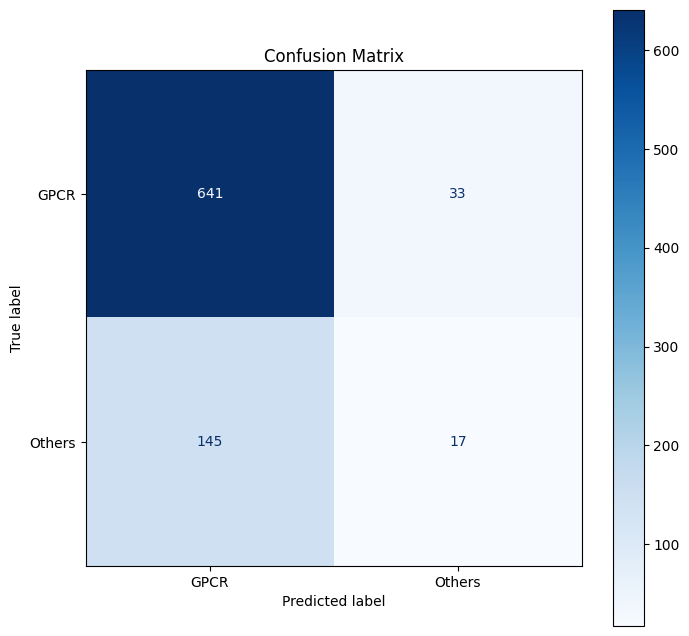

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Modèles LSTM pour classification binaire Protease

In [ ]:
gpcr2 = load_fasta_and_encode("GPCR.fasta")
protease2 = load_fasta_and_encode("Protease.fasta")
p4502 = load_fasta_and_encode("P450.fasta")
ferritin2 = load_fasta_and_encode("Ferritin.fasta")

In [ ]:
gpcr2 = np.stack((gpcr2, np.ones(gpcr2.shape)), axis=1)
protease2 = np.stack((protease2, np.zeros(protease2.shape)), axis=1)
p4502 = np.stack((p4502, np.ones(p4502.shape)), axis=1)
ferritin2 = np.stack((ferritin2, np.ones(ferritin2.shape)), axis=1)

In [ ]:
df_sequences_binary2 = pd.DataFrame(np.vstack((gpcr2, protease2, p4502, ferritin2)), columns=["sequences", "label"])
df_sequences_binary2

,sequences,label
0,"[11, 6, 6, 4, 1, 6, 1, 3, 6, 13, 15, 6, 15, 18...",1.0
1,"[11, 15, 10, 10, 1, 10, 16, 6, 10, 10, 2, 11, ...",1.0
2,"[11, 7, 15, 7, 8, 10, 8, 10, 5, 10, 5, 6, 2, 1...",1.0
3,"[11, 16, 12, 5, 17, 13, 3, 1, 2, 12, 18, 3, 16...",1.0
4,"[11, 9, 18, 10, 2, 17, 18, 10, 18, 18, 17, 10,...",1.0
...,...,...
4170,"[11, 16, 17, 9, 17, 12, 18, 18, 4, 18, 10, 12,...",1.0
4171,"[11, 12, 9, 14, 18, 8, 4, 18, 10, 12, 9, 14, 1...",1.0
4172,"[11, 9, 17, 8, 12, 16, 18, 3, 17, 9, 4, 5, 10,...",1.0
4173,"[17, 4, 10, 6, 17, 3, 13, 12, 1, 9, 17, 13, 16...",1.0


In [ ]:
positives2 = df_sequences_binary2[df_sequences_binary2["label"] == 0].reset_index(drop=True)
negatives2 = df_sequences_binary2[df_sequences_binary2["label"] == 1].reset_index(drop=True)

In [ ]:
positives2 = shuffle(positives2)
negatives2 = shuffle(negatives2)

In [ ]:
X_trainbp2, X_testbp2, y_trainbp2, y_testbp2 = train_test_split(positives2["sequences"], positives2["label"], test_size=0.2, random_state=42)
X_trainbn2, X_testbn2, y_trainbn2, y_testbn2 = train_test_split(negatives2["sequences"], negatives2["label"], test_size=0.2, random_state=42)

In [ ]:
X_test2 = np.array(pd.concat([X_testbp2, X_testbn2]))
y_test2 = np.array(pd.concat([y_testbp2, y_testbn2]))

In [ ]:
X_test2 = pad_sequences(X_test2, padding='post', maxlen=7839)
y_test2 = y_test2.astype("float32")

In [ ]:
positives2 = pd.concat([X_trainbp2, y_trainbp2], axis=1)
negatives2 = pd.concat([X_trainbn2, y_trainbn2], axis=1)

In [ ]:
positives2_sequences = pad_sequences(np.array(positives2['sequences']), padding='pre', maxlen=7839)
positives2_labels = np.array(positives2['label']).astype('int32')

In [ ]:
chunks2, chunk_labels2 = CreateChunk(negatives2['sequences'], negatives2['label'], 200)

In [ ]:
for i in range(len(chunks2)):
  chunks2[i] = pad_sequences(chunks2[i], padding='pre', maxlen=7839)

In [ ]:
input_layer_b2 = Input(shape=(7839,), dtype="int32")

x = layers.Embedding(input_dim=21, output_dim=8)(input_layer_b2)
x = layers.Bidirectional(LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(LSTM(128))(x)

output_layer2 = layers.Dense(1, activation="sigmoid")(x)

model_lstm_b2 = Model(inputs=input_layer_b2, outputs=output_layer2)
model_lstm_b2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 7839)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 7839, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 7839, 128)      │        37,376 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,969 (1.15 MB)

 Trainable params: 300,969 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint('best_model_lstm_b2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_lstm_b2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(len(chunks2)):
    X_train2 = np.vstack((chunks2[i], positives2_sequences)).astype('int32')
    y_train2 = np.concatenate((np.array(chunk_labels2[i]), positives2_labels)).astype('float32')
    model_lstm_b2.fit(X_train2, y_train2, epochs=5, batch_size=64, validation_data=(X_test2, y_test2), callbacks=[mc])

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5660 - loss: 0.6751
Epoch 1: val_accuracy improved from -inf to 0.12440, saving model to best_model_lstm_b2.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5719 - loss: 0.6742 - val_accuracy: 0.1244 - val_loss: 0.8063
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6798 - loss: 0.6309
Epoch 2: val_accuracy did not improve from 0.12440
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6794 - loss: 0.6311 - val_accuracy: 0.1244 - val_loss: 0.8154
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6766 - loss: 0.6202
Epoch 3: val_accuracy improved from 0.12440 to 0.14952, saving model to best_model_lstm_b2.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6764 - loss: 0.6200 - val_accuracy: 0.1495 - val_loss: 0.7042
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6844 - loss: 0.5927
Epoch 4: val_accuracy improved from 0.14952 to 0.87560, saving model to best_model_ls

In [ ]:
y_pred_probs2 = model_lstm_b2.predict(X_test2)
y_pred2 = (y_pred_probs2 > 0.5).astype("float32")

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step


In [ ]:
print("\nClassification Report:")
class_names = ['Protease', 'Others']
print(classification_report(y_test2, y_pred2, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    Protease       0.00      0.00      0.00       104
      Others       0.88      1.00      0.93       732

    accuracy                           0.88       836
   macro avg       0.44      0.50      0.47       836
weighted avg       0.77      0.88      0.82       836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


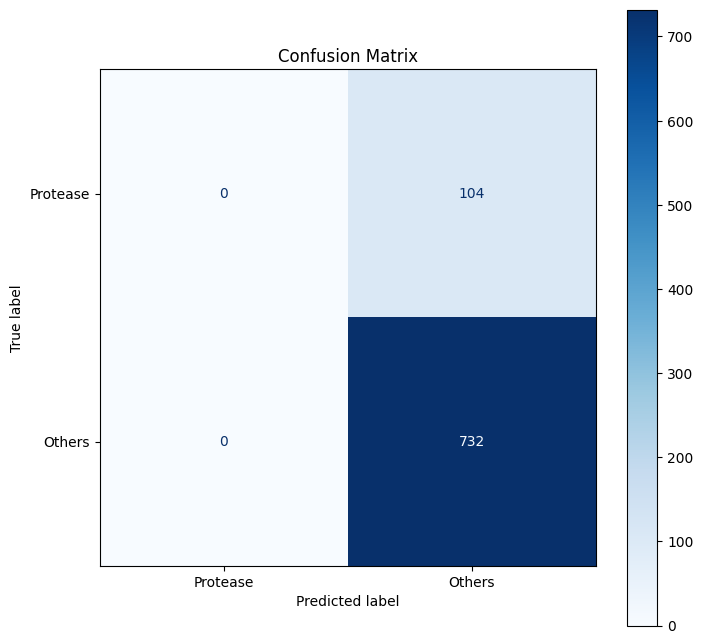

In [ ]:
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Modèles LSTM pour classification binaire P450

In [ ]:
gpcr3 = load_fasta_and_encode("GPCR.fasta")
protease3 = load_fasta_and_encode("Protease.fasta")
p4503 = load_fasta_and_encode("P450.fasta")
ferritin3 = load_fasta_and_encode("Ferritin.fasta")

gpcr3 = np.stack((gpcr3, np.ones(gpcr3.shape)), axis=1)
protease3 = np.stack((protease3, np.ones(protease3.shape)), axis=1)
p4503 = np.stack((p4503, np.zeros(p4503.shape)), axis=1)
ferritin3 = np.stack((ferritin3, np.ones(ferritin3.shape)), axis=1)

df_sequences_binary3 = pd.DataFrame(np.vstack((gpcr3, protease3, p4503, ferritin3)), columns=["sequences", "label"])
df_sequences_binary3

positives3 = df_sequences_binary3[df_sequences_binary3["label"] == 0].reset_index(drop=True)
negatives3 = df_sequences_binary3[df_sequences_binary3["label"] == 1].reset_index(drop=True)

positives3 = shuffle(positives3)
negatives3 = shuffle(negatives3)

X_trainbp3, X_testbp3, y_trainbp3, y_testbp3 = train_test_split(positives3["sequences"], positives3["label"], test_size=0.2, random_state=42)
X_trainbn3, X_testbn3, y_trainbn3, y_testbn3 = train_test_split(negatives3["sequences"], negatives3["label"], test_size=0.2, random_state=42)

X_test3 = np.array(pd.concat([X_testbp3, X_testbn3]))
y_test3 = np.array(pd.concat([y_testbp3, y_testbn3]))

X_test3 = pad_sequences(X_test3, padding='post', maxlen=7839)
y_test3 = y_test3.astype("float32")

positives3 = pd.concat([X_trainbp3, y_trainbp3], axis=1)
negatives3 = pd.concat([X_trainbn3, y_trainbn3], axis=1)

positives3_sequences = pad_sequences(np.array(positives3['sequences']), padding='pre', maxlen=7839)
positives3_labels = np.array(positives3['label']).astype('int32')

chunks3, chunk_labels3 = CreateChunk(negatives3['sequences'], negatives3['label'], 100)

for i in range(len(chunks3)):
  chunks3[i] = pad_sequences(chunks3[i], padding='pre', maxlen=7839)



In [ ]:
input_layer_b3 = Input(shape=(7839,), dtype="int32")

x = layers.Embedding(input_dim=21, output_dim=8)(input_layer_b3)
x = layers.Bidirectional(LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(LSTM(128))(x)

output_layer3 = layers.Dense(1, activation="sigmoid")(x)

model_lstm_b3 = Model(inputs=input_layer_b3, outputs=output_layer3)
model_lstm_b3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7839)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 7839, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7839, 128)      │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,969 (1.15 MB)

 Trainable params: 300,969 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint('best_model_lstm_b3.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_lstm_b3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(len(chunks3)):
    X_train3 = np.vstack((chunks3[i], positives3_sequences)).astype('int32')
    y_train3 = np.concatenate((np.array(chunk_labels3[i]), positives3_labels)).astype('float32')
    model_lstm_b3.fit(X_train3, y_train3, epochs=5, batch_size=64, validation_data=(X_test3, y_test3), callbacks=[mc])

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6744 - loss: 0.6828
Epoch 1: val_accuracy improved from -inf to 0.06100, saving model to best_model_lstm_b3.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6733 - loss: 0.6812 - val_accuracy: 0.0610 - val_loss: 0.8160
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6739 - loss: 0.6452
Epoch 2: val_accuracy did not improve from 0.06100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6729 - loss: 0.6454 - val_accuracy: 0.0610 - val_loss: 0.7941
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.6942 - loss: 0.6218
Epoch 3: val_accuracy did not improve from 0.06100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6898 - loss: 0.6242 - val_accuracy: 0.0610 - val_loss: 0.7719
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.6656 - loss: 0.6369
Epoch 4: val_accuracy did not improve from 0.06100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6660 - loss: 0.6364 - val_accuracy

In [ ]:
y_pred_probs3 = model_lstm_b3.predict(X_test3)
y_pred3 = (y_pred_probs3 > 0.5).astype("float32")

In [ ]:
print("\nClassification Report:")
class_names = ['Protease', 'Others']
print(classification_report(y_test3, y_pred3, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test3, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()